In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arrow
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import queue
import cv2
import time
import pickle


In [2]:
P_TRUE = 0.90
FREESPACE_ALPHA = 0.05
PAD = 1e-6

In [3]:
class OccupancySpace:
    
    def __init__(self, x, y, freespace):
        self.x = x
        self.y = y
        self.freespace = freespace
        
    def __str__(self):
        return f'({self.x}, {self.y})'

class Pose(OccupancySpace):
    THETA_LIST = [i * np.pi / 2 for i in range(0, 4)]
    
    def __init__(self, x, y, theta):
        super().__init__(x, y, freespace=1e-6)
        self.theta = theta
        self.cost = np.inf
        self.parent = None
        
    def compute_cost(self, other):
        dtheta = (self.theta - other.theta)
        if abs(dtheta) > np.pi:
            dtheta = abs(dtheta) - np.pi
        return np.linalg.norm([self.x - other.x, self.y - other.y, 1*dtheta])
    
    def get_neighbors(self, grid, cell_width=0.5):
        ret = []
        
        dx, dy = cell_width * round(np.cos(self.theta)), cell_width * round(np.sin(self.theta)) # compute possible dx, dy based on theta (can only drive straight)
        # NEED TO FIX THIS
        if  self.x + dx >= 0 and self.y + dy >= 0 \
            and self.x + dx < grid.xoffset + grid.xlim \
            and self.y + dy < grid.yoffset + grid.ylim \
            and grid.pose_grid[(self.x + dx, self.y + dy)].freespace <= FREESPACE_ALPHA:
            # print((self.x + dx, self.y + dy), grid.pose_grid[(self.x + dx, self.y + dy)].freespace)
            ret.append((self.x + dx, self.y + dy, self.theta))
            
        for t in Pose.THETA_LIST: # add in turns
            if self.theta != t:
                ret.append((self.x, self.y, t))

        return ret
                       
    def __lt__(self, other):
        return self.cost < other.cost # for priority queue
    
    def __str__(self):
        return f'({self.x}, {self.y}, {self.theta})'
    
    def round(self, cell_width=0.5):
        """Truncates, not round..."""
        self.x = int(self.x / cell_width) * cell_width
        self.y = int(self.y / cell_width) * cell_width
        self.theta = round(self.theta * 4 / np.pi) / 4 * np.pi

In [4]:
class OccupancyGrid:
    
    def __init__(self, grid_array, xoffset=0, yoffset=0, cell_width=0.5):
        self.xoffset = xoffset
        self.yoffset = yoffset
        self.cell_width = cell_width
        self.make_map(grid_array)
    
    def make_map(self, grid_array):
        self.pose_grid = {}
        for x in range(grid_array.shape[0]):
            for y in range(grid_array.shape[1]):
                self.pose_grid[(x * self.cell_width + self.xoffset, y * self.cell_width + self.yoffset)] = OccupancySpace(x * self.cell_width + self.xoffset, y * self.cell_width + self.yoffset, freespace=grid_array[x,y])
        
        self.xlim = grid_array.shape[0] * self.cell_width
        self.ylim = grid_array.shape[1] * self.cell_width
    
    def get_freespace(self, x, y):
        return self.pose_grid[(x,y)].freespace        
    
    def to_idx(self, position):
        x, y = position
        return int(x / self.cell_width - self.xoffset), int(y / self.cell_width - self.yoffset)
    
    def to_array(self):
        new_grid = np.zeros((int(self.xlim / self.cell_width), int(self.ylim / self.cell_width)))
        for x,y in self.pose_grid:
            i,j = self.to_idx((x,y))
            new_grid[i,j] = self.pose_grid[(x,y)].freespace
            
        return new_grid
    
    def get_freespace_nodes(self):
        positions = []
        for x,y in self.pose_grid:
            if self.pose_grid[(x,y)].freespace <= FREESPACE_ALPHA:
                for theta in Pose.THETA_LIST:
                    positions.append((x,y,theta))
        
        return positions
        

class ExplorationGrid(OccupancyGrid):
    
    def __init__(self, grid_array, explore_grid, ptrue, xoffset=0, yoffset=0, cell_width=0.5):
        super().__init__(grid_array, xoffset, yoffset, cell_width)
        self.ptrue = ptrue
        self.explore_grid = OccupancyGrid(explore_grid, xoffset, yoffset, cell_width)
    
    def occupied_update(self, pij):
        return self.ptrue * pij / (self.ptrue * pij + (1 - self.ptrue) * (1 - pij))
    
    def unoccupied_update(self, pij):
        return 1 - self.ptrue * (1 - pij) / (self.ptrue * (1 - pij) + (1 - self.ptrue) * pij)
    
    def measurement_update(self, o, x, y):
        pij = self.explore_grid.pose_grid[(x,y)].freespace
        if o > 0.5:
            self.explore_grid.pose_grid[(x,y)].freespace = self.occupied_update(pij)
        else:
            self.explore_grid.pose_grid[(x,y)].freespace = self.unoccupied_update(pij)  
            
    def E(self, x, y):
        pij = self.explore_grid.pose_grid[(x,y)].freespace
        return -P_TRUE * pij * np.log(P_TRUE * pij / (P_TRUE * pij + (1-P_TRUE) * (1-pij)) + PAD) - P_TRUE * (1-pij) * np.log(P_TRUE * (1-pij) / (P_TRUE * (1-pij) + (1-P_TRUE) * pij) + PAD)
            
    def Hp(self, x, y):
        pij = self.explore_grid.pose_grid[(x,y)].freespace
        return -pij * np.log(pij + PAD) - (1-pij) * np.log(1-pij + PAD)
    

    def EIG(self, x, y):
        return self.Hp(x,y) - self.E(x,y)
    
        
    def plot(self, axs, start=None, goal=None, path=None):
        assert len(axs) == 2
        
        visualize(self, axs[0], start=start, goal=goal, path=path)
        visualize(self.explore_grid, axs[1], start=start, goal=goal, path=path)
        axs[0].set_title('Occupancy Grid')
        axs[1].set_title('Exploration Grid')


def visualize(grid, ax, start=None, goal=None, path=None):
        grid_array = grid.to_array()
        ax.imshow(1 - grid_array.T, 
                    aspect='equal', 
                    cmap='gray',
                    extent=[0, grid_array.shape[0] * grid.cell_width, 0, grid_array.shape[1] * grid.cell_width], 
                    origin='lower',
                    vmin=0,
                    vmax=1)
                
        if start != None:
            ax.add_patch(Rectangle((start.x, start.y), grid.cell_width, grid.cell_width, linewidth=1, edgecolor='Red', facecolor='Red'))
            ax.add_patch(Arrow(start.x,
                                start.y,
                                0.2 * np.cos(start.theta),
                                0.2 * np.sin(start.theta),
                                width=0.6,
                                edgecolor='Blue',
                                facecolor='Blue'))
        
        if goal != None: ax.add_patch(Rectangle((goal.x, goal.y), grid.cell_width, grid.cell_width, linewidth=1, edgecolor='Green', facecolor='Green'))
        
        if path != None: # draw the path
            for node in path:
                ax.add_patch(Arrow(node.x,
                                node.y,
                                0.2 * np.cos(node.theta),
                                0.2 * np.sin(node.theta),
                                width=0.6,
                                edgecolor='Blue',
                                facecolor='Blue'))
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        # ax.set_xticks(np.arange(grid.xoffset, grid.xlim + grid.xoffset + grid.cell_width, grid.cell_width))
        # ax.set_yticks(np.arange(grid.yoffset, grid.ylim + grid.yoffset + grid.cell_width, grid.cell_width))
        ax.set_aspect('equal', adjustable='box')
        

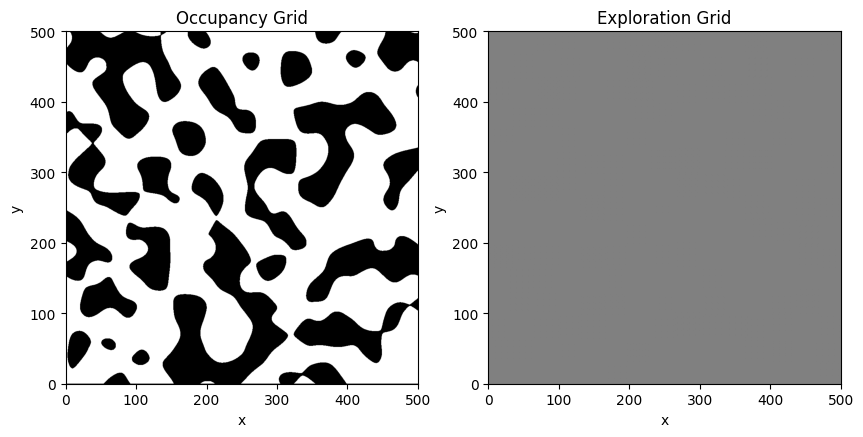

In [12]:
grid_array = pickle.load(open('maps/map1000.pkl', 'rb'))
explore_array = np.ones(grid_array.shape) * 0.5
grid = ExplorationGrid(grid_array, explore_array, P_TRUE)
fig, axs = plt.subplots(nrows=1, ncols=2)
grid.plot(axs)
fig.set_size_inches((10,5))
plt.show()

  4%|▍         | 2/50 [00:05<02:21,  2.95s/it]


KeyboardInterrupt: 

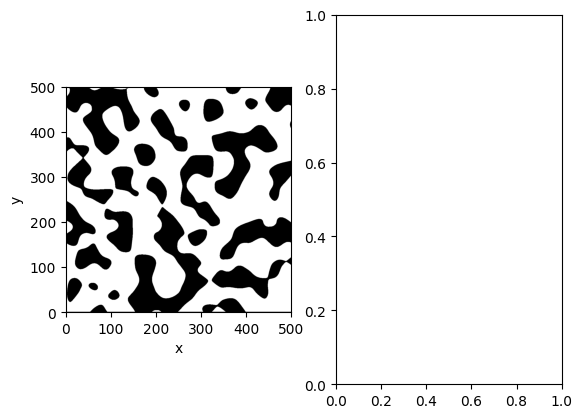

In [13]:
UPDATES = 50
filenames = []

for i in tqdm(range(UPDATES)):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    for x, y in grid.pose_grid:
        o = grid.pose_grid[(x,y)].freespace
        o = 1 - o if np.random.random() > P_TRUE else o
        grid.measurement_update(o, x, y)
    grid.plot(axs)
    fig.set_size_inches((10,4))
    fig.tight_layout()
    filenames.append(rf'/Users/neiljanwani/Documents/exploration-scrat/images/test/image{i}.png')
    plt.savefig(filenames[-1])
    plt.close()

In [5]:
def corrupted_measurement(grid, x, y, theta):
    dx, dy = grid.cell_width * round(np.cos(theta)), grid.cell_width * round(np.sin(theta))
    dx2, dy2 = grid.cell_width * round(np.cos(theta + np.pi / 2)), grid.cell_width * round(np.sin(theta + np.pi / 2))
    measured = [(x + dx2, y + dy2), (x - dx2, y - dy2)] + [(x + dx, y + dy)] + [(x + dx + dx2, y + dy + dy2), (x - dx2 + dx, y - dy2 + dy)]
    # print(measured)
    for x,y in measured:
        if x >= 0 and y >= 0 and x < grid.xlim + grid.xoffset and y < grid.ylim + grid.yoffset:
            o = grid.pose_grid[(x,y)].freespace
            o = 1 - o if np.random.random() > P_TRUE else o
            grid.measurement_update(o, x, y)

def corrupted_EIG(grid, x, y, theta):
    dx, dy = grid.cell_width * np.round(np.cos(theta)), grid.cell_width * np.round(np.sin(theta))
    dx2, dy2 = grid.cell_width * np.round(np.cos(theta + np.pi / 2)), grid.cell_width * np.round(np.sin(theta + np.pi / 2))
    # print(np.round(np.cos(theta)), np.round(np.sin(theta)), np.round(np.cos(theta + np.pi / 2)), np.round(np.sin(theta + np.pi / 2)))
    # print(dx, dy, dx2, dy2)
    # print(x,y,theta)
    # print('----')
    assert dx != dx2
    assert dy != dy2
    measured = [(x + dx2, y + dy2), (x - dx2, y - dy2)] + [(x + dx, y + dy)] + [(x + dx + dx2, y + dy + dy2), (x - dx2 + dx, y - dy2 + dy)]
    totalEIG = 0
    mbool = [v[0]<0 or v[1]<0 for v in measured]
    # if any(mbool):
    #     print('AHH', measured)
    i = 0
    for x,y in measured:
        if x >= 0 and y >= 0 and x < grid.xlim + grid.xoffset and y < grid.ylim + grid.yoffset:
            totalEIG += grid.EIG(x,y)
            i += 1
    return totalEIG / i

def unknown_area(grid, x,y,theta):
    dx, dy = grid.cell_width * np.round(np.cos(theta)), grid.cell_width * np.round(np.sin(theta))
    dx2, dy2 = grid.cell_width * np.round(np.cos(theta + np.pi / 2)), grid.cell_width * np.round(np.sin(theta + np.pi / 2))
    measured = [(x + dx2, y + dy2), (x - dx2, y - dy2)] + [(x + dx, y + dy)] + [(x + dx + dx2, y + dy + dy2), (x - dx2 + dx, y - dy2 + dy)]
    for x,y in measured:
        if x >= 0 and y >= 0 and x < grid.xlim + grid.xoffset and y < grid.ylim + grid.yoffset:
            if not (grid.pose_grid[x,y].freespace < FREESPACE_ALPHA or grid.pose_grid[x,y].freespace > 1 - FREESPACE_ALPHA):
                return True
    return False

def add_pose(grid, point_to_pose, pose):
    grid.explore_grid.pose_grid[(pose.x, pose.y)].freespace = pose.freespace
    for theta in Pose.THETA_LIST:
        point_to_pose[(pose.x, pose.y, pose.theta)] = Pose(pose.x, pose.y, theta)
    
    return point_to_pose

In [6]:
def waypoint_gen(grid, start, goal):
    """
    Function requested in prelab. Uses Dijkstra's

    Args:
        grid (numpy array): grid description of world, 0 = fresespace and 1 = obstacle
        start (Pose): Pose object for starting location. ASSUMES THIS IS ROUNDED
        goal (Pose): Pose object for requested ending location. ASSUMES THIS IS ROUNDED

    Returns:
        list: list of Pose objects representing the start to goal path if it exists
    """
    start.round()
    goal.round()
    point_to_pose = {} # assemble a dictionary relating (x,y,theta) to Pose object (need this to store cost/parent)
    for x,y in grid.pose_grid:
        if grid.pose_grid[x,y].freespace <= FREESPACE_ALPHA:
            for theta in Pose.THETA_LIST:
                # print('MADE A POSE')
                point_to_pose[(grid.pose_grid[x,y].x, grid.pose_grid[x,y].y, theta)] = Pose(grid.pose_grid[x,y].x, grid.pose_grid[x,y].y, theta)
                
    point_to_pose[(start.x, start.y, start.theta)] = start
    point_to_pose[(goal.x, goal.y, goal.theta)] = goal
    start.cost = start.compute_cost(start)

    onDeck = queue.PriorityQueue()
    onDeck.put(start)
    iters = 0
    # print(point_to_pose.keys())
    # print(start)
    # print(goal)
    # print('--')
    while True:
        if onDeck.empty():
            return None
        
        iters += 1
        node = onDeck.get()
        # print(node)
        if node == goal:
            break
        for neighbor_point in node.get_neighbors(grid):
            # print(neighbor_point)
            neighbor = point_to_pose[neighbor_point]
            new_cost = neighbor.compute_cost(start) + node.cost
            if new_cost < neighbor.cost: # only search if neighbor is 'more optimal'
                neighbor.cost = new_cost
                neighbor.parent = node
                onDeck.put(neighbor)
        # print('iter')

    node = goal
    path = [goal]
    while node != start: # construct path
        path.append(node.parent)
        node = node.parent
        
    # fig, ax = plt.subplots()
    # visualize(ax, grid, start, goal, path)
    # fig.suptitle('Grid world')
    # plt.show()
    path.reverse()
    return path

# EIG EXPLORE

KeyboardInterrupt: 

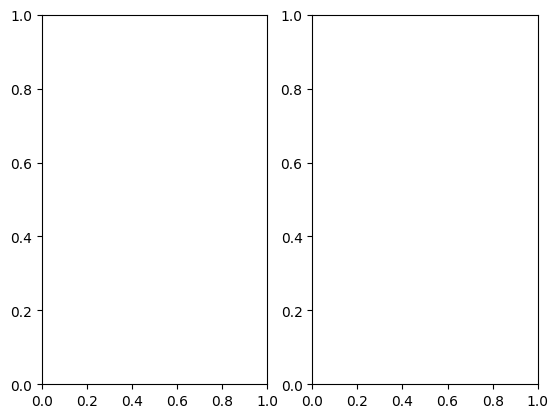

In [42]:
grid_array = pickle.load(open('maps/map20.pkl', 'rb'))
# grid_array = np.zeros((12,12))
explore_array = np.ones(grid_array.shape) * 0.5
grid = ExplorationGrid(grid_array, explore_array, P_TRUE)
metric_eig_20 = []

fig, axs = plt.subplots(nrows=1, ncols=2)

start = Pose(1, 0.5, np.pi / 2)
pose = start

grid.explore_grid.pose_grid[start.x, start.y].freespace = 0
iters = 1000

filenames = []
i = 0

while True:
    positions = grid.explore_grid.get_freespace_nodes()
    positions = sorted(positions, key=lambda v: -1 * corrupted_EIG(grid, *v))

    while True:
        goal = Pose(*positions[0])
        path = waypoint_gen(grid.explore_grid, pose, goal)
        if path != None:
            break
        positions = positions[1:]
    pose = path[1]
    if i % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=2)
        grid.plot(axs, start=pose, goal=goal, path=path)
        fig.set_size_inches((10,5))
        fig.tight_layout()
        filenames.append(rf'/Users/neiljanwani/Documents/exploration-scrat/images/simple/image{i}.png')
        plt.savefig(filenames[-1])
        plt.close()
    corrupted_measurement(grid, pose.x, pose.y, pose.theta)
    metric_eig_20.append(np.mean([int(grid.explore_grid.pose_grid[(x,y)].freespace < FREESPACE_ALPHA or grid.explore_grid.pose_grid[(x,y)].freespace > 1 - FREESPACE_ALPHA) for x,y in grid.pose_grid]))
    print(metric_eig_20[-1], end='\r')
    # input()
    i += 1
# 0.3286

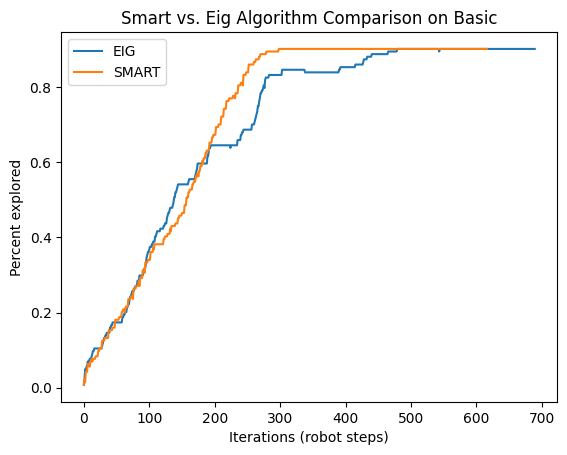

In [49]:
fig, ax = plt.subplots()
ax.plot(metric_eig_basic, label='EIG')
ax.plot(mapbasic_metric, label='SMART')
# ax.plot(map20_metric, label = 'Map 20x20')
# ax.plot(map30_metric, label = 'Map 30x30')
# ax.plot(map50_metric, label = 'Map 50x50')
ax.set_xlabel('Iterations (robot steps)')
ax.set_ylabel('Percent explored')
ax.set_title('Smart vs. Eig Algorithm Comparison on Basic')
plt.legend()
plt.savefig('/Users/neiljanwani/Documents/exploration-scrat/images/graphs/basic_eigvsmart')

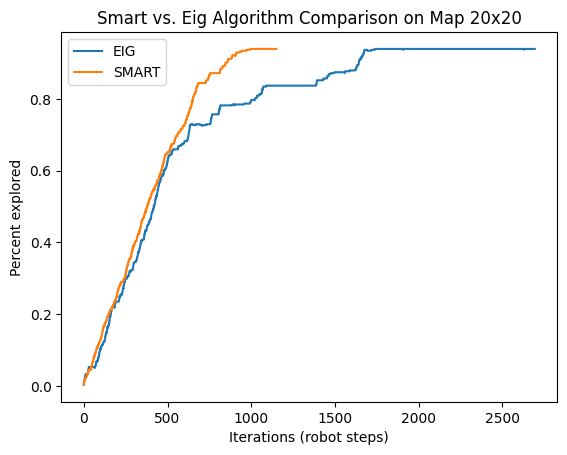

In [50]:
fig, ax = plt.subplots()
ax.plot(metric_eig_20, label='EIG')
ax.plot(map20_metric, label='SMART')
# ax.plot(map20_metric, label = 'Map 20x20')
# ax.plot(map30_metric, label = 'Map 30x30')
# ax.plot(map50_metric, label = 'Map 50x50')
ax.set_xlabel('Iterations (robot steps)')
ax.set_ylabel('Percent explored')
ax.set_title('Smart vs. Eig Algorithm Comparison on Map 20x20')
plt.legend()
plt.savefig('/Users/neiljanwani/Documents/exploration-scrat/images/graphs/map20_eigvssmart')

KeyboardInterrupt: 

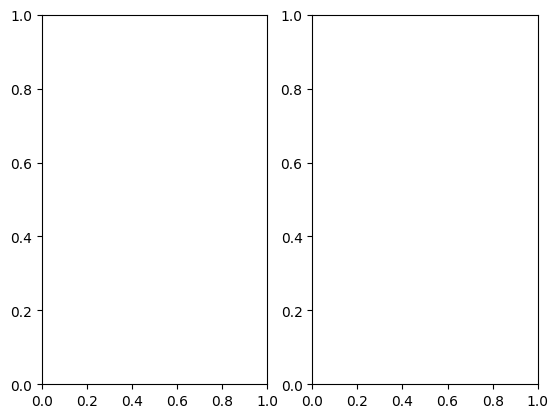

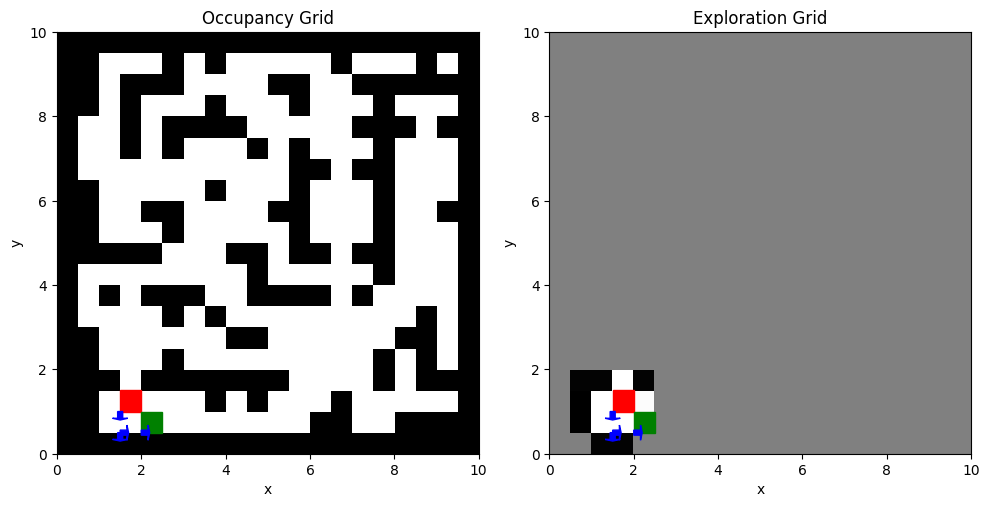

In [52]:
grid_array = pickle.load(open('maps/map20.pkl', 'rb'))
# grid_array = np.zeros((12,12))
explore_array = np.ones(grid_array.shape) * 0.5
grid = ExplorationGrid(grid_array, explore_array, P_TRUE)

fig, axs = plt.subplots(nrows=1, ncols=2)

start = Pose(1, 0.5, np.pi / 2)
pose = start

grid.explore_grid.pose_grid[start.x, start.y].freespace = 0
iters = 1000

filenames = []
i = 0
path = []

while True:
    positions = grid.explore_grid.get_freespace_nodes()
    positions = sorted(positions, key=lambda v: corrupted_EIG(grid, *v), reverse=True)

    # print(pose)
    # for i in range(3):
    #     print(positions[i], ':', corrupted_EIG(grid, *positions[i]) + 0*pose.compute_cost(Pose(*positions[i])))
    # print()

    # print(corrupted_EIG(grid, *positions[0]))
    while path == []:
        goal = Pose(*positions[0])
        path = waypoint_gen(grid.explore_grid, pose, goal)
        if path != None:
            break
        else:
            path = []
        positions = positions[1:]
    # assert True if len(path) < 3 else path[0] != path[2]
    pose = path[0]
    path = path[1:]
    if i % 1 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=2)
        grid.plot(axs, start=pose, goal=goal, path=path)
        fig.set_size_inches((10,5))
        fig.tight_layout()
        filenames.append(rf'/Users/neiljanwani/Documents/exploration-scrat/images/map20_eig/image{i}.png')
        plt.savefig(filenames[-1])
        plt.close()
    if unknown_area(grid.explore_grid, pose.x, pose.y, pose.theta):
        corrupted_measurement(grid, pose.x, pose.y, pose.theta)
        path = []
        # print('making measurement')
    print(np.mean([int(grid.explore_grid.pose_grid[(x,y)].freespace < FREESPACE_ALPHA or grid.explore_grid.pose_grid[(x,y)].freespace > 1 - FREESPACE_ALPHA) for x,y in grid.pose_grid]), end='\r')
    # input()
    i += 1


# SMART EXPLORE

KeyboardInterrupt: 

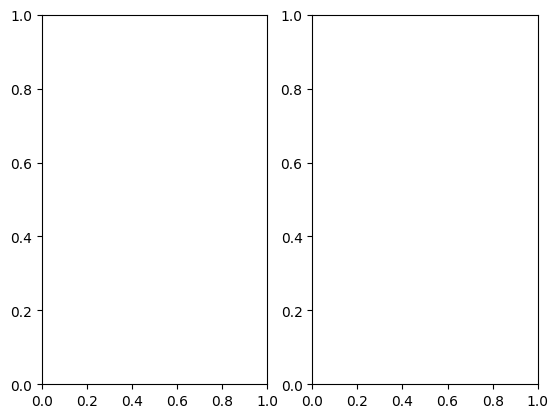

In [27]:
grid_array = pickle.load(open('maps/mapsm_09.pkl', 'rb'))
map50_metric = []
# grid_array = np.zeros((12,12))
explore_array = np.ones(grid_array.shape) * 0.5
grid = ExplorationGrid(grid_array, explore_array, P_TRUE)

fig, axs = plt.subplots(nrows=1, ncols=2)

start = Pose(1, 0.5, np.pi / 2)
pose = start

grid.explore_grid.pose_grid[start.x, start.y].freespace = 0
iters = 1000

filenames = []
i = 0
path = []

while True:
    positions = grid.explore_grid.get_freespace_nodes()
    positions = sorted(positions, key=lambda v:  (corrupted_EIG(grid, *v) / (pose.compute_cost(Pose(*v)) + 1), corrupted_EIG(grid, *v)), reverse=True)

    # print(pose)
    # for i in range(3):
    #     print(positions[i], ':', corrupted_EIG(grid, *positions[i]) + 0*pose.compute_cost(Pose(*positions[i])))
    # print()

    # print(corrupted_EIG(grid, *positions[0]))
    while path == []:
        goal = Pose(*positions[0])
        path = waypoint_gen(grid.explore_grid, pose, goal)
        if path != None:
            break
        else:
            path = []
        positions = positions[1:]
    # assert True if len(path) < 3 else path[0] != path[2]
    pose = path[0]
    path = path[1:]
    if i % 1 == -1:
        fig, axs = plt.subplots(nrows=1, ncols=2)
        grid.plot(axs, start=pose, goal=goal, path=path)
        fig.set_size_inches((10,5))
        fig.tight_layout()
        filenames.append(rf'/Users/neiljanwani/Documents/exploration-scrat/images/mapbasic_smart/image{i}.png')
        plt.savefig(filenames[-1])
        plt.close()
    if unknown_area(grid.explore_grid, pose.x, pose.y, pose.theta):
        corrupted_measurement(grid, pose.x, pose.y, pose.theta)
        path = []
        # print('making measurement')
    map50_metric.append(np.mean([int(grid.explore_grid.pose_grid[(x,y)].freespace < FREESPACE_ALPHA or grid.explore_grid.pose_grid[(x,y)].freespace > 1 - FREESPACE_ALPHA) for x,y in grid.pose_grid]))
    print(map50_metric[-1], end='\r')
    # input()
    i += 1

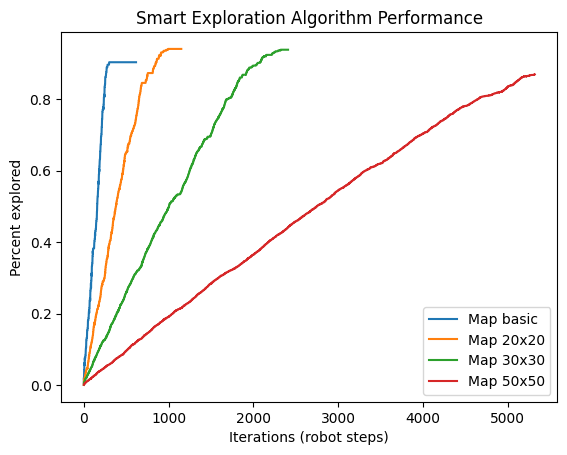

In [51]:
fig, ax = plt.subplots()
ax.plot(mapbasic_metric, label='Map basic')
ax.plot(map20_metric, label = 'Map 20x20')
ax.plot(map30_metric, label = 'Map 30x30')
ax.plot(map50_metric, label = 'Map 50x50')
ax.set_xlabel('Iterations (robot steps)')
ax.set_ylabel('Percent explored')
ax.set_title('Smart Exploration Algorithm Performance')
plt.legend()
plt.savefig('/Users/neiljanwani/Documents/exploration-scrat/images/graphs/smart_explore_performance')

# DIRECTED EXPLORE

0.006944444444444444
0.020833333333333332
0.020833333333333332
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.0625
0.0625
0.0625
0.0763888888888889
0.08333333333333333
0.09027777777777778
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222
0.09722222222222222


KeyboardInterrupt: 

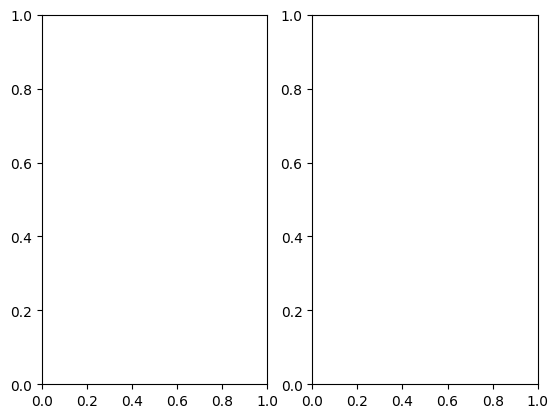

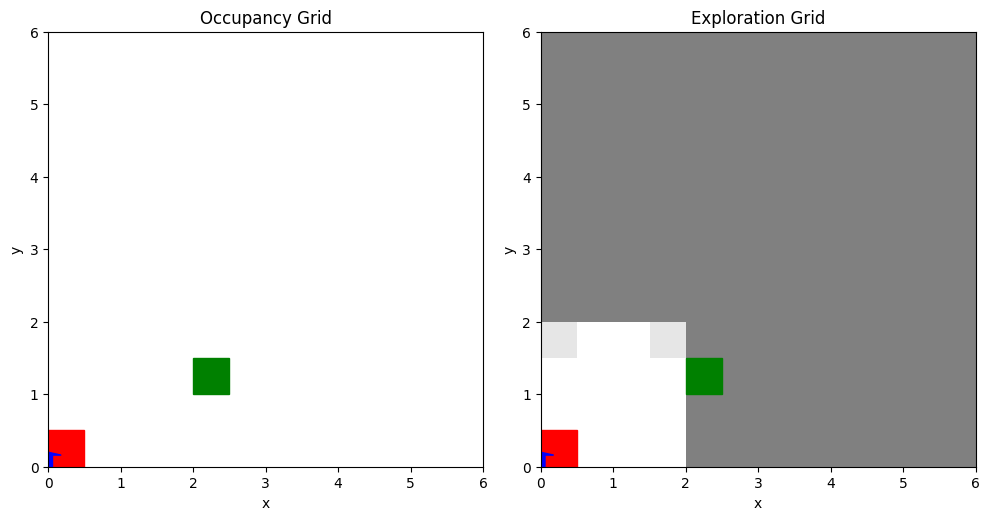

In [25]:
grid_array = pickle.load(open('maps/map20.pkl', 'rb'))
grid_array = np.zeros((12,12))
explore_array = np.ones(grid_array.shape) * 0.5
grid = ExplorationGrid(grid_array, explore_array, P_TRUE)

fig, axs = plt.subplots(nrows=1, ncols=2)

start = Pose(1, 0.5, np.pi / 2)
pose = start

grid.explore_grid.pose_grid[start.x, start.y].freespace = 0
iters = 1000

filenames = []
i = 0

goals = [(2,1,0), (1,2,0), (6,5,0)]
cgoal = 0
path = []

while True:
    if pose.x == goals[cgoal][0] and pose.y == goals[cgoal][1]:
        cgoal += 1
        print("GOAL REACHED!")
    cgoal %= len(goals)
    
    positions = grid.explore_grid.get_freespace_nodes()
    positions = sorted(positions, key=lambda v:  (0*corrupted_EIG(grid, *v) + 0.1 * pose.compute_cost(Pose(*goals[cgoal])), 0*corrupted_EIG(grid, *v)), reverse=False)
    
    while len(path) == 0:
        goal = Pose(*positions[0])
        path = waypoint_gen(grid.explore_grid, pose, goal)
        if path != None:
            path = path[1:]
            break
        else:
            path = []
        positions = positions[1:]
    # assert True if len(path) < 3 else path[0] != path[2]
    pose = path.pop(0)
    if i % 1 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=2)
        grid.plot(axs, start=pose, goal=Pose(*goals[cgoal]), path=None)
        fig.set_size_inches((10,5))
        fig.tight_layout()
        filenames.append(rf'/Users/neiljanwani/Documents/exploration-scrat/images/map20_smart/image{i}.png')
        plt.savefig(filenames[-1])
        plt.close()
    corrupted_measurement(grid, pose.x, pose.y, pose.theta)
    print(np.mean([int(grid.explore_grid.pose_grid[(x,y)].freespace < FREESPACE_ALPHA or grid.explore_grid.pose_grid[(x,y)].freespace > 1 - FREESPACE_ALPHA) for x,y in grid.pose_grid]), end='\n')
    # input()
    i += 1


In [14]:
import cv2
import time
 
img_array = []
for filename in filenames[:-1]:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter(f'/Users/neiljanwani/Documents/exploration-scrat/images/final/exploration_{str(time.asctime()).replace(" ","_").replace(":","-")}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
filenames